In [12]:
from matplotlib import pyplot
from tensorflow import keras
import pickle
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from urllib.request import urlretrieve
from os.path import isfile, isdir
from tqdm import tqdm 
import tarfile
cifar10_dataset_folder_path = 'cifar-10-batches-py'

In [13]:
cifar10_dataset_folder_path = 'cifar-10-batches-py'

class DownloadProgress(tqdm):
    last_block = 0

    def hook(self, block_num=1, block_size=1, total_size=None):
        self.total = total_size
        self.update((block_num - self.last_block) * block_size)
        self.last_block = block_num

""" 
    check if the data (zip) file is already downloaded
    if not, download it from "https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz" and save as cifar-10-python.tar.gz
"""
if not isfile('cifar-10-python.tar.gz'):
    with DownloadProgress(unit='B', unit_scale=True, miniters=1, desc='CIFAR-10 Dataset') as pbar:
        urlretrieve(
            'https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz',
            'cifar-10-python.tar.gz',
            pbar.hook)

if not isdir(cifar10_dataset_folder_path):
    with tarfile.open('cifar-10-python.tar.gz') as tar:
        tar.extractall()
        tar.close()


CIFAR-10 Dataset: 171MB [00:02, 84.8MB/s]                           


In [14]:
#function to read data from all 5 batches of train data with labels
def load_cfar10_batch(cifar10_dataset_folder_path):
    image = []
    label = []
#each batch data is (10000 x 3072) matrix expressed in numpy
#to feed this into our model we are reshaping the input data into (32*32*3) width x height x num_channel using reshape and transpose 
    for i in range(1,6):
      with open(cifar10_dataset_folder_path + '/data_batch_' + str(i), mode='rb') as file:
            batch = pickle.load(file, encoding='latin1')
            image.append(batch['data'])
            label.append(batch['labels'])
    return np.array(image).reshape(50000,3072).reshape((50000,3, 32, 32)).transpose(0,2,3,1), np.array(label).reshape(50000)
   

In [15]:
train_image, train_lables = load_cfar10_batch(cifar10_dataset_folder_path)
print(train_image.shape)
print(len(train_lables))
#create a list of the label names
label_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

(50000, 32, 32, 3)
50000


horse


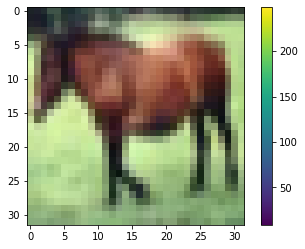

In [16]:
#printing a sample image along with label
print(label_names[train_lables[7]])
plt.figure()
plt.imshow(train_image[7])
plt.colorbar()
plt.grid(False)
plt.show()

In [17]:
#function to normalize the data using min_max  normalizer
def normalize(x):
  min_val = np.min(x)
  max_val = np.max(x)
  x = (x-min_val)/(max_val - min_val)
  return x

In [18]:
train_image = normalize(train_image)
print(train_image.shape)

(50000, 32, 32, 3)


In [19]:
#function to load the test data
def load_test_data(cifar10_dataset_folder_path):
  with open(cifar10_dataset_folder_path + '/test_batch', mode='rb') as file:
      batch = pickle.load(file, encoding='latin1')
  return batch["data"].reshape((len(batch['data']),3, 32, 32)).transpose(0,2,3,1), batch["labels"]

In [20]:
#load the test image and the corresponding class
test_image, test_labels = load_test_data(cifar10_dataset_folder_path)
test_image.shape
test_image = normalize(test_image)
test_labels = np.array(test_labels)

In [30]:
from tensorflow.keras import datasets, layers, models
#building the model by specifying the different layers
model = keras.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
#display summary of the model trainable parameters
model.summary()


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 30, 30, 32)        896       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 13, 13, 32)        9248      
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 3, 3, 64)          36928     
Total params: 65,568
Trainable params: 65,568
Non-trainable params: 0
__________________________________________________

In [32]:
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(10))
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 30, 30, 32)        896       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 13, 13, 32)        9248      
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 3, 3, 64)          36928     
_________________________________________________________________
flatten_2 (Flatten)          (None, 576)              

In [33]:
#specifying other model parameters 
opt = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=opt,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [34]:
#training the model by specifying a validation split of 25%
history = model.fit(train_image, train_lables,batch_size = 32,validation_split=0.33, epochs=50)

Epoch 1/50
1047/1047 [==============================] - 59s 56ms/step - loss: 1.9666 - accuracy: 0.2466 - val_loss: 1.7323 - val_accuracy: 0.3492
Epoch 2/50
1047/1047 [==============================] - 59s 57ms/step - loss: 1.6574 - accuracy: 0.3801 - val_loss: 1.6045 - val_accuracy: 0.4045
Epoch 3/50
1047/1047 [==============================] - 59s 57ms/step - loss: 1.5680 - accuracy: 0.4147 - val_loss: 1.5929 - val_accuracy: 0.4104
Epoch 4/50
1047/1047 [==============================] - 60s 57ms/step - loss: 1.5087 - accuracy: 0.4387 - val_loss: 1.5001 - val_accuracy: 0.4460
Epoch 5/50
1047/1047 [==============================] - 59s 56ms/step - loss: 1.4534 - accuracy: 0.4608 - val_loss: 1.4476 - val_accuracy: 0.4584
Epoch 6/50
1047/1047 [==============================] - 59s 57ms/step - loss: 1.4074 - accuracy: 0.4784 - val_loss: 1.4128 - val_accuracy: 0.4849
Epoch 7/50
1047/1047 [==============================] - 58s 55ms/step - loss: 1.3616 - accuracy: 0.5016 - val_loss: 1.3664 -

In [35]:
#Evaluate accuracy on test data
test_loss, test_acc = model.evaluate(test_image,test_labels, verbose=2)

313/313 - 4s - loss: 1.0451 - accuracy: 0.6619


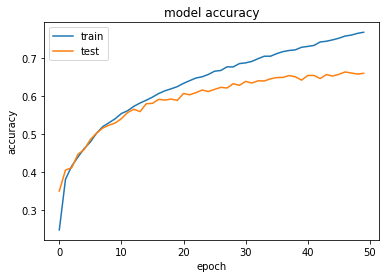

In [36]:
#plot of accuracy on the training and validation datasets over training epochs.
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

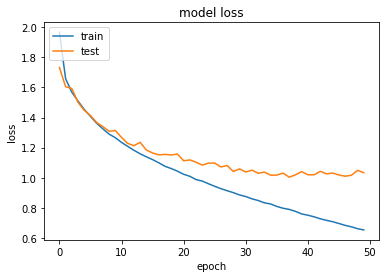

In [37]:
# plot of loss on the training and validation datasets over training epochs.
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [38]:
#making predictions using the model - Softmax layer is used to convert the logits to probabilities
probability_model = tf.keras.Sequential([model, tf.keras.layers.Softmax()])
predictions = probability_model.predict(test_image)

In [ ]:
#function to plot the test image and specify it's true and predicted label
def plot_image(i, predictions_array, true_label, img):
  predictions_array, true_label, img = predictions_array, true_label[i], img[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])

  plt.imshow(img, cmap=plt.cm.binary)

  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'

  plt.xlabel("{} {:2.0f}% ({})".format(label_names[predicted_label],
                                100*np.max(predictions_array),
                                label_names[true_label]),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
  predictions_array, true_label = predictions_array, true_label[i]
  plt.grid(False)
  plt.xticks(range(10))
  plt.yticks([])
  thisplot = plt.bar(range(10), predictions_array, color="#777777")
  plt.ylim([0, 1])
  predicted_label = np.argmax(predictions_array)

  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('blue')

ValueError: ignored

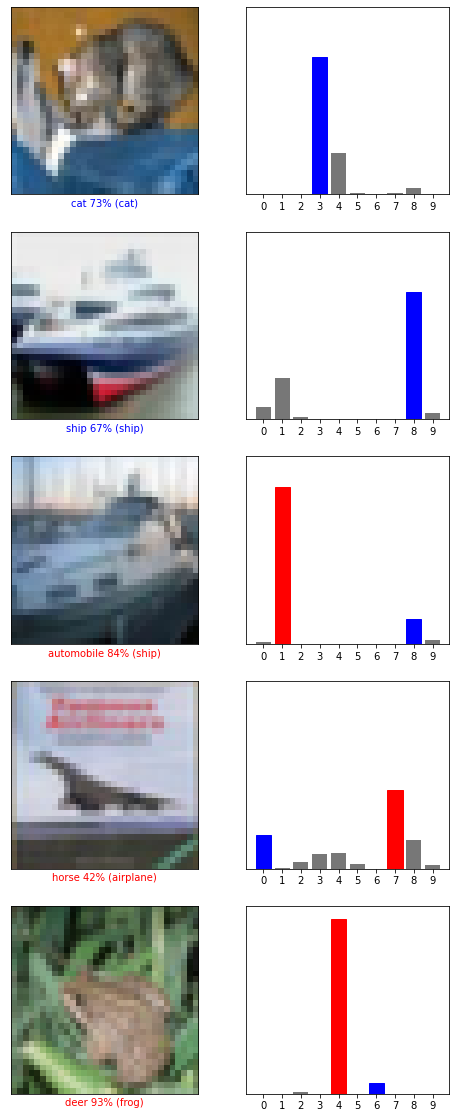

In [ ]:
num_cols = 2
num_rows = 5
plt.figure(figsize=(4*num_cols,4*num_rows))
for i in range(0,6):
    plt.subplot(num_rows, num_cols, 2*i+1)
    plot_image(i, predictions[i], test_labels, test_image)
    plt.subplot(num_rows, num_cols, 2*i+2)
    plot_value_array(i, predictions[i],  test_labels)
plt.tight_layout()
plt.show()